In [1]:
import os

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupShuffleSplit
import umap
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:

seed_value = 1234

In [3]:
# # Mount GDrive and attach it to the colab for data I/O
# from google.colab import drive
# drive.mount('/content/drive')
# data_folder = '/content/drive/My Drive/ML4HC_Final_Project/data/input/feature_extraction/'
data_folder = './../../datum/reddit/input/feature_extraction/'

In [56]:
plt.style.use('seaborn-bright')
plt.figure(figsize=(12, 10), dpi= 100, facecolor='w', edgecolor='k')

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

In [4]:
def unison_shuffled_copies(a, b, c):
    assert len(a) == len(b) == len(c)
    p = np.random.permutation(len(a))
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)
    return a[p], b[p], c[p]

In [57]:
def scatter_plot(X_reduced, y, color_code, method, annotate = False, title = 'title', savefig = False ):
    plt.clf()


    
    #     Shuffle
    X_reduced, y, color_code = unison_shuffled_copies(X_reduced, y, color_code)

    # plot     
    c = LabelEncoder().fit_transform(color_code) #encode to integers
    c = [n*100 for n in c]
    scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1],c=c, alpha=0.6, s=2)
    label_names = [str(n) for n in np.unique(y)] 
    label_names.sort()
    plt.legend(handles=scatter.legend_elements()[0], labels=label_names)
    if annotate:
        for i, txt in enumerate(annotate_names):
            plt.annotate(txt, (X_reduced[:, 0][i], X_reduced[:, 1][i]))

    if title:
        plt.title(title)
    if savefig:
        plt.savefig('./data/'+title.replace('/', '-')+'.png', dpi=150)
    plt.show()

In [22]:
umap

<module 'umap' from '/Users/danielmlow/miniconda3/lib/python3.7/site-packages/umap/__init__.py'>

In [28]:
def run_umap(X=None, y=None, method = 'unsupervised', scaler=None, neighbor = 10, dist=0.1, metric='correlation', color_code = None, annotate_names = None, 
              annotate = False, test_set = True, title=None, savefig = False, X_test=None, y_test=None, color_code_test = None, plot=plot):
    reducer = umap.UMAP(n_components=dimension, n_neighbors = neighbor, min_dist=dist,metric=metric,random_state=seed_value) #, TSNE(n_components=k, random_state=seed_value), PCA(n_components=k, random_state=seed_value)]
    reducer_name = 'umap' #, 'tsne', 'pca']

    pipeline = Pipeline([
        ('normalization', scaler),
        ('reducer', reducer), ])

    if method == 'supervised':
        X_reduced = pipeline.fit_transform(X, y)
    elif method == 'metric_learning':
        X_reduced = pipeline.fit_transform(X, y)
        X_reduced_test = pipeline.transform(X_test)
        
    elif method == 'unsupervised':
        X_reduced = pipeline.fit_transform(X)
        
    # Plot in 2D
    if plot == True:
        assert dimension == 2 
        if method == 'metric_learning':
            # train: first time point
            scatter_plot(X_reduced, y, color_code, method, annotate = annotate, title = 'First time step (train set)', savefig = savefig )
            # test: next time points            
            scatter_plot(X_reduced_test, y_test, color_code_test, method, annotate = annotate, title = title, savefig = savefig )
            return X_reduced, X_reduced_test
        else:
            scatter_plot(X_reduced, y, color_code, method, annotate = annotate, title = title, savefig = savefig )
            return X_reduced


def scatter_X_reduced(X_reduced, color_code, annotate_names):
    plt.clf()
    plt.figure(figsize=(12, 10), dpi= 100, facecolor='w', edgecolor='k')

    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=color_code, alpha=0.8, s=6)
    if annotate:
        for i, txt in enumerate(annotate_names):
            plt.annotate(txt, (X_reduced[:, 0][i], X_reduced[:, 1][i]))
    plt.show()
    
    
def gridsearch_sets(metrics, n_neighbors, min_dist, n_dimensions, scalers, repeat):
    gridsearch  = []
    for metric in metrics:
        for neighbor in n_neighbors:
            for dist in min_dist:
                for dimension in n_dimensions:
                    for scaler in scalers:
                        for r in repeat:
                            gridsearch.append([metric,neighbor,dist,dimension,scaler, r])
    return gridsearch

## Load data with our without subsampling

In [11]:
# subreddits = ['EDAnonymous', 'addiction', 'adhd', 'alcoholism', 'anxiety',
#  'bipolarreddit', 'bpd',  'depression',  'healthanxiety',
#        'jokes', 'legaladvice', 'meditation', 'mentalhealth',
#        'mentalillness', 'mindfulness', 'paranoia', 
#        'personalfinance','ptsd', 'schizophrenia', 'socialanxiety', 
#        'suicidewatch']

In [12]:
X_i.shape

NameError: name 'X_i' is not defined

In [13]:
def subsample_df(df, subsample, overN):
  if df.shape[0] > subsample_subreddits_overN:
    subsample_int = int(df.shape[0]*subsample)
    df = df.loc[np.random.choice(df.index,subsample_int, replace=False)]
  return df

In [14]:

subsample = 0.2 #False or 0.2 
subsample_subreddits_overN = 25000 #subsample if dataset > N, set to 0 for all


subreddits = ['depression', 'healthanxiety', 'mindfulness', 'socialanxiety', 'suicidewatch']
# Careful: if you add COVID19_support and it does not exist in the first time step, then this will confuse metric learning
subreddits.sort()



reddit_data = pd.read_csv(data_folder +subreddits[0]+'_post_features.csv', index_col=False)
if subsample:
  reddit_data = subsample_df(reddit_data, subsample, subsample_subreddits_overN)

for i in np.arange(1, len(subreddits)):
  new_data = pd.read_csv(data_folder+subreddits[i]+'_post_features.csv')
  print(new_data.shape)
  new_data = subsample_df(new_data, subsample, subsample_subreddits_overN)
  print(new_data.shape)
  reddit_data = pd.concat([reddit_data, new_data], axis=0)




(5352, 88)
(5352, 88)
(1131, 88)
(1131, 88)
(5928, 88)
(5928, 88)
(37931, 88)
(7586, 88)


In [15]:
counts = reddit_data.groupby(["subreddit", "date"]).size().reset_index(name='count')
for sr in subreddits:
  counts_d = counts[counts.subreddit == sr].mean()
  print(sr, ': ', np.round(float(counts_d),2))

depression :  125.41
healthanxiety :  48.22
mindfulness :  10.19
socialanxiety :  53.41
suicidewatch :  68.34


In [16]:
reddit_data.tail()
features = list(reddit_data.columns)

features = [n for n in features if n not in ['subreddit','author','date','post']]

print('double check features: ',features)
posts = np.array(reddit_data.subreddit.value_counts()).astype(int)
days = np.unique(reddit_data.date)



double check features:  ['automated_readability_index', 'coleman_liau_index', 'flesch_kincaid_grade_level', 'flesch_reading_ease', 'gulpease_index', 'gunning_fog_index', 'lix', 'smog_index', 'wiener_sachtextformel', 'n_chars', 'n_long_words', 'n_monosyllable_words', 'n_polysyllable_words', 'n_sents', 'n_syllables', 'n_unique_words', 'n_words', 'sent_neg', 'sent_neu', 'sent_pos', 'sent_compound', 'punctuation', '1st_pers', '2nd_pers', '3rd_pers', 'achievement', 'adverbs', 'affective_processes', 'anger', 'anxiety', 'articles_article', 'assent', 'auxiliary_verbs', 'biological', 'body', 'causation', 'certainty', 'cognitive', 'common_verbs', 'conjunctions', 'death', 'discrepancy', 'exclusive', 'family', 'feel', 'fillers', 'friends', 'future_tense', 'health', 'hear', 'home', 'humans', 'impersonal_pronouns', 'inclusive', 'ingestion', 'inhibition', 'insight', 'leisure', 'money', 'motion', 'negations', 'negative_emotion', 'nonfluencies', 'numbers', 'past_tense', 'perceptual_processes', 'persona


## Build X, y by grouping data by timestep (e.g., per week)

In [272]:
timestep = 25

X = []
y = []
for i in range(0,len(days),timestep):
  days_week = days[i:i+timestep]
  df_week = reddit_data[reddit_data.date.isin(days_week)]
  df_week_feature_cols = df_week[features].values
  df_week_y = list(df_week.subreddit)
  X.append(df_week_feature_cols)
  y.append(df_week_y)


In [273]:
X = np.array(X)
y = np.array(y)

In [19]:
days_week = days[::timestep]
len(days)

111

2020/01/01
====metric: correlation,  48 neighbor (low=maintain local structure),  0.1 dist (low=tightly packed),  2D======


/Users/danielmlow/miniconda3/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../miniconda3/lib/python3.7/site-packages/umap/utils.py", line 409:
@numba.njit(parallel=True)
def build_candidates(current_graph, n_vertices, n_neighbors, max_candidates, rng_state):
^

  current_graph, n_vertices, n_neighbors, max_candidates, rng_state
/Users/danielmlow/miniconda3/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../..

<Figure size 432x288 with 0 Axes>

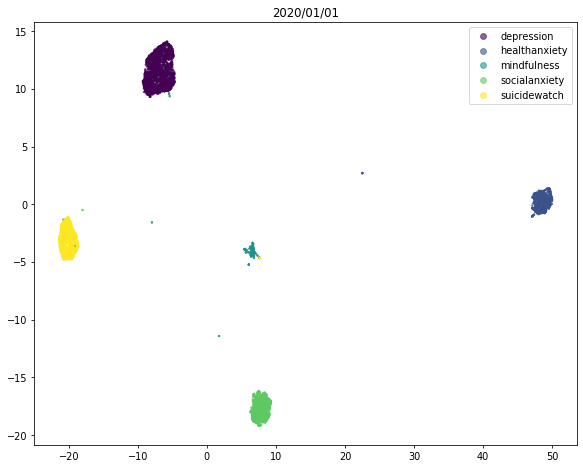

In [29]:
# Plot 2D for each timestep


method = 'supervised'# 'metric_learning', 'supervised', 'unsupervised'
savefig = False
plot=True
annotate = False
annotate_names = False
run_Ntimesteps = 1 #len(X) 


for i, (X_i, y_i) in enumerate(zip(X[:run_Ntimesteps],y[:run_Ntimesteps])):
    if method  == 'metric_learning' and i==0:
        print('doing metric learning, train on first sample and test on rest')
        color_code = y[0].copy()
        continue

    print(days_week[i])
    if method == 'metric_learning':
        color_code_test = y_i.copy()
    else:
        color_code = y_i.copy()
    # groups = LabelEncoder().fit_transform(groups)
    n_dimensions =  [2,]#4,8,16,32,64,128] # https://umap-learn.readthedocs.io/en/latest/parameters.html
    n_neighbors = [48]#[8,16,24,32,40,48,56, 64]#15,20] # CANNOT USE MORE THAN N participants, default=10 Lower values seem to work better in 2D. This means that low values of n_neighbors will force UMAP to concentrate on very local structure
    min_dist = [0.1]#[0.01, 0.1, 0.5, 1]#[0, 0.001,0.01, 0.1, 0.5]#0.25, 0.5, 0.75]  # default=0.1. Lower values seem to work better in 2D. controls how tightly UMAP is allowed to pack points together. Larger values of min_dist will prevent UMAP from packing point together and will focus instead on the preservation of the broad topological structure instead.
    metrics = ['correlation'] # cosine adds points?
    repeat_n = 1
    repeat = [1]*repeat_n # to check how much randomness is affecting results, one can repeat
    scalers = [StandardScaler()]

    gridsearch= gridsearch_sets(metrics, n_neighbors, min_dist, n_dimensions, scalers, repeat)
    for metric,neighbor,dist,dimension,scaler, r in gridsearch:
        print('====metric: {},  {} neighbor (low=maintain local structure),  {} dist (low=tightly packed),  {}D======'.format(metric,neighbor,dist,dimension))
        if method == 'metric_learning':
            # need to add train and test (the last arguments)             
            X_reduced, X_reduced_test = run_umap(X = X[0], y = y[0], method=method,  scaler = scaler, neighbor = neighbor , dist=dist, metric='correlation', 
                  color_code = color_code, annotate_names = annotate_names, annotate = annotate, title=days_week[i],
                 savefig = savefig, X_test = X_i, y_test=y_i, color_code_test = color_code_test, plot = plot)
        else:    
            X_reduced = run_umap(X = X_i, y = y_i, method = method, scaler=  scaler, neighbor = neighbor , dist=dist, metric='correlation', 
                  color_code = color_code, annotate_names = annotate_names, annotate = annotate, title=days_week[i],
                 savefig = savefig, plot = plot)


In [204]:

from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances


k = len(subreddits)
km = KMeans(n_clusters = k, random_state = seed_value).fit(X_reduced)
kmeans_labels = KMeans(n_clusters = k, random_state = seed_value).fit_predict(X_reduced)
dists = euclidean_distances(km.cluster_centers_)
tri_dists = dists[np.triu_indices(5, 1)]
max_dist, avg_dist, min_dist = tri_dists.max(), tri_dists.mean(), tri_dists.min()



In [231]:
(a,b)

(array([ -6.93309  ,  48.743065 ,   7.7742324, -20.208435 ,  -6.93309  ,
         48.743065 ,   7.7742324,   6.825261 ,  -6.93309  ,  48.743065 ,
        -20.208435 ,   6.825261 ,  -6.93309  ,   7.7742324, -20.208435 ,
          6.825261 ,  48.743065 ,   7.7742324, -20.208435 ,   6.825261 ],
       dtype=float32),
 array([ 11.505086  ,   0.22684425, -17.754875  ,  -3.0501318 ,
         11.505086  ,   0.22684425, -17.754875  ,  -3.9269261 ,
         11.505086  ,   0.22684425,  -3.0501318 ,  -3.9269261 ,
         11.505086  , -17.754875  ,  -3.0501318 ,  -3.9269261 ,
          0.22684425, -17.754875  ,  -3.0501318 ,  -3.9269261 ],
       dtype=float32))

In [240]:
[[a[i],b[i]],
                  a[i+1],b[i+1],
                 ]

[[-6.93309, 11.505086], 48.743065, 0.22684425]

In [249]:
len(a)

20

In [251]:
distances = []
x_0, y_0 = a[0], b[0]
for i in range(len(a))[:-1]:
    if i == len(a):
            two_points = np.array([[a[i],b[i]],
                  [a[0],b[0]],
                 ])
    else:
        two_points = np.array([[a[i],b[i]],
                      [a[i+1],b[i+1]],
                     ])
    print(two_points)
    d = euclidean_distances(two_points)
    print(d[0][1])
    distances.append(d[0][1])
    
    


[[-6.93309    11.505086  ]
 [48.743065    0.22684425]]
56.80698
[[ 48.743065     0.22684425]
 [  7.7742324  -17.754875  ]]
44.74134
[[  7.7742324 -17.754875 ]
 [-20.208435   -3.0501318]]
31.611061
[[-20.208435   -3.0501318]
 [ -6.93309    11.505086 ]]
19.699978
[[-6.93309    11.505086  ]
 [48.743065    0.22684425]]
56.80698
[[ 48.743065     0.22684425]
 [  7.7742324  -17.754875  ]]
44.74134
[[  7.7742324 -17.754875 ]
 [  6.825261   -3.9269261]]
13.860474
[[ 6.825261  -3.9269261]
 [-6.93309   11.505086 ]]
20.674604
[[-6.93309    11.505086  ]
 [48.743065    0.22684425]]
56.80698
[[ 48.743065     0.22684425]
 [-20.208435    -3.0501318 ]]
69.02933
[[-20.208435   -3.0501318]
 [  6.825261   -3.9269261]]
27.04791
[[ 6.825261  -3.9269261]
 [-6.93309   11.505086 ]]
20.674604
[[ -6.93309    11.505086 ]
 [  7.7742324 -17.754875 ]]
32.74829
[[  7.7742324 -17.754875 ]
 [-20.208435   -3.0501318]]
31.611061
[[-20.208435   -3.0501318]
 [  6.825261   -3.9269261]]
27.04791
[[ 6.825261   -3.9269261 ]
 [4

In [252]:
len(distances)

19

In [237]:
km.cluster_centers_

array([[ -6.93309   ,  11.505086  ],
       [ 48.743065  ,   0.22684425],
       [  7.7742324 , -17.754875  ],
       [-20.208435  ,  -3.0501318 ],
       [  6.825261  ,  -3.9269261 ]], dtype=float32)

In [228]:
dists = euclidean_distances(km.cluster_centers_)
dists

array([[ 0.      , 56.80698 , 32.74829 , 19.699978, 20.674604],
       [56.80698 ,  0.      , 44.74134 , 69.02933 , 42.123108],
       [32.74829 , 44.74134 ,  0.      , 31.611061, 13.860474],
       [19.699978, 69.02933 , 31.611061,  0.      , 27.04791 ],
       [20.674604, 42.123108, 13.860474, 27.04791 ,  0.      ]],
      dtype=float32)

In [205]:
dists = euclidean_distances(km.cluster_centers_)
dists = pd.DataFrame(dists, columns = subreddits, index=subreddits)
dists

,depression,healthanxiety,mindfulness,socialanxiety,suicidewatch
depression,0.000000,56.806980,32.748291,19.699978,20.674604
healthanxiety,56.806980,0.000000,44.741341,69.029327,42.123108
mindfulness,32.748291,44.741341,0.000000,31.611061,13.860474
socialanxiety,19.699978,69.029327,31.611061,0.000000,27.047911
suicidewatch,20.674604,42.123108,13.860474,27.047911,0.000000


In [265]:
for x,y in zip(a,b):
    print(x,y)

-6.93309 11.505086
48.743065 0.22684425
7.7742324 -17.754875
-20.208435 -3.0501318
-6.93309 11.505086
48.743065 0.22684425
7.7742324 -17.754875
6.825261 -3.9269261
-6.93309 11.505086
48.743065 0.22684425
-20.208435 -3.0501318
6.825261 -3.9269261
-6.93309 11.505086
7.7742324 -17.754875
-20.208435 -3.0501318
6.825261 -3.9269261
48.743065 0.22684425
7.7742324 -17.754875
-20.208435 -3.0501318
6.825261 -3.9269261


In [278]:
# https://stackoverflow.com/questions/52911890/labeling-distance-between-points-on-python-plot
def plot_lines(X):
    k = len(subreddits)
    km = KMeans(n_clusters = k, random_state = seed_value).fit(X_reduced)
    kmeans_labels = KMeans(n_clusters = k, random_state = seed_value).fit_predict(X_reduced)
    dists = euclidean_distances(km.cluster_centers_)
    tri_dists = dists[np.triu_indices(5, 1)]
    max_dist, avg_dist, min_dist = tri_dists.max(), tri_dists.mean(), tri_dists.min()




    import itertools
    combs = list(itertools.combinations(centers,4))
    combs = [n for i in combs for n in i]
    combs = np.array(combs)
    combs
    dists = euclidean_distances(combs)
    print(dists.shape, combs.shape)



    plt.clf()
    plt.style.use('seaborn-bright')
    plt.figure(figsize=(10, 8), dpi= 100, facecolor='w', edgecolor='k')
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=kmeans_labels, s=1, cmap='Spectral');
    # Centroids
    plt.scatter(
        km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
        s=10, marker='x',
        c='magenta', edgecolor='black',
        label='centroids')

    # LINES
#     plt.plot(a,b) # this works
    for i in range(len(a)):
        if i == len(a):
            break
        plt.plot(a[i:i+1], b[i:i+1])
#     plt.text(0.9, 0.2, 'cos')
    

2020/04/10
====metric: correlation,  48 neighbor (low=maintain local structure),  0.1 dist (low=tightly packed),  2D======
(20, 20) (20, 2)


<Figure size 432x288 with 0 Axes>

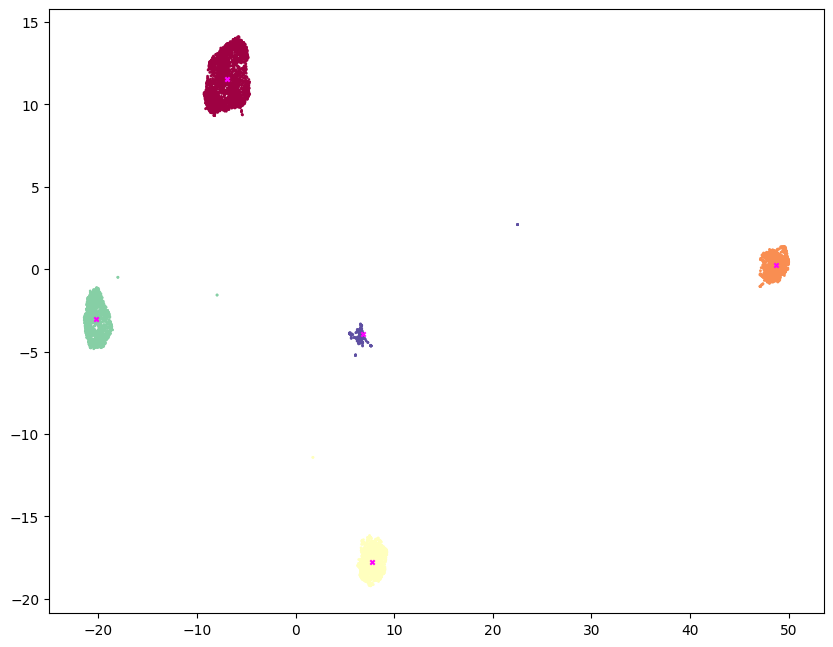

In [279]:
# Plot 2D for each timestep


method = 'supervised'# 'metric_learning', 'supervised', 'unsupervised'
savefig = False
plot=True
annotate = False
annotate_names = False
run_Ntimesteps = 1 #len(X) 


for i, (X_i, y_i) in enumerate(zip(X[:run_Ntimesteps],y[:run_Ntimesteps])):
    if method  == 'metric_learning' and i==0:
        print('doing metric learning, train on first sample and test on rest')
        color_code = y[0].copy()
        continue

    print(days_week[i])
    if method == 'metric_learning':
        color_code_test = y_i.copy()
    else:
        color_code = y_i.copy()
    # groups = LabelEncoder().fit_transform(groups)
    n_dimensions =  [2,]#4,8,16,32,64,128] # https://umap-learn.readthedocs.io/en/latest/parameters.html
    n_neighbors = [48]#[8,16,24,32,40,48,56, 64]#15,20] # CANNOT USE MORE THAN N participants, default=10 Lower values seem to work better in 2D. This means that low values of n_neighbors will force UMAP to concentrate on very local structure
    min_dist = [0.1]#[0.01, 0.1, 0.5, 1]#[0, 0.001,0.01, 0.1, 0.5]#0.25, 0.5, 0.75]  # default=0.1. Lower values seem to work better in 2D. controls how tightly UMAP is allowed to pack points together. Larger values of min_dist will prevent UMAP from packing point together and will focus instead on the preservation of the broad topological structure instead.
    metrics = ['correlation'] # cosine adds points?
    repeat_n = 1
    repeat = [1]*repeat_n # to check how much randomness is affecting results, one can repeat
    scalers = [StandardScaler()]

    gridsearch= gridsearch_sets(metrics, n_neighbors, min_dist, n_dimensions, scalers, repeat)
    for metric,neighbor,dist,dimension,scaler, r in gridsearch:
        print('====metric: {},  {} neighbor (low=maintain local structure),  {} dist (low=tightly packed),  {}D======'.format(metric,neighbor,dist,dimension))
        if method == 'metric_learning':
            # need to add train and test (the last arguments)             
            plot_lines(X)
        else:    
            plot_lines(X)


## How much do they agree?
 evaluating the adjusted Rand score and adjusted mutual information for this clustering as compared with the true labels.

In [44]:

from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

(
    adjusted_rand_score(y_i, kmeans_labels),
    adjusted_mutual_info_score(y_i, kmeans_labels)
)

/Users/danielmlow/miniconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


(0.9897922787956482, 0.9724335466869521)

In [178]:
!pip install matplotlib-label-lines

You should consider upgrading via the 'pip install --upgrade pip' command.


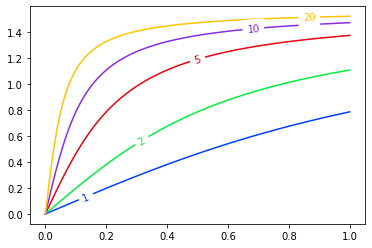

In [179]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import loglaplace,chi2

from labellines import labelLine, labelLines

X = np.linspace(0,1,500)
A = [1,2,5,10,20]
funcs = [np.arctan,np.sin,loglaplace(4).pdf,chi2(5).pdf]

# plt.subplot(321)
for a in A:
    plt.plot(X,np.arctan(a*X),label=str(a))

labelLines(plt.gca().get_lines(),zorder=2.5)

In [120]:

filenames

['2020-02-20.png',
 '2020-01-01.png',
 '2020-03-16.png',
 '2020-04-10.png',
 '2020-01-26.png']

In [96]:
input_dir = '/Users/danielmlow/Dropbox (MIT)/libs/reddit/data/timestep_{}/'.format(timestep)
filenames = os.listdir(input_dir)
# images = []
# for filename in filenames:
#     images.append(imageio.imread(input_dir+filename))
# imageio.mimsave(input_dir+'supervised.gif', images)

In [97]:
import imageio
with imageio.get_writer(input_dir+'supervised.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(input_dir+filename)
        writer.append_data(image)